In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from hs2 import herdingspikes
from probe import NeuroPixel
from sklearn.cluster import DBSCAN
import numpy as np
import heapq

%matplotlib inline

In [2]:
# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames

user = "Cole"

if user == "Hennig":
    data_path = '/disk/scratch/mhennig/neuropixel/data/rawDataSample.bin'
elif user == "Martino":
    data_path = "data/rawDataSample.bin"
else:
    data_path = '/home/cole/neuropixeldata/rawDataSample.bin'

to_localize = True
cutout_start = 10
cutout_end = 30
threshold = 12
masking = None
file_name = 'ProcessedSpikes'


In [3]:
Probe = NeuroPixel(data_file_path=data_path, fps=30000, masked_channels=masking)

H = herdingspikes(Probe)

In [4]:
H.DetectFromRaw(to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0)

# # OR

# H.LoadDetected()

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 200000
# Analysing 200000 frames; -42 200055
# Analysing 200000 frames; 199958 400055
# Analysing 200000 frames; 399958 600055
# Analysing 200000 frames; 599958 800055
# Analysing 200000 frames; 799958 1000055
# Analysing 200000 frames; 999958 1200055
# Analysing 200000 frames; 1199958 1400055
# Analysing 200000 frames; 1399958 1600055
# Analysing 199945 frames; 1599958 1800000
# Time taken for detection: 0:00:14.296060
# Time per frame: 0:00:00.007942
# Time per sample: 0:00:00.000021
Detected and read 385265 spikes.


In [5]:
H.CombinedClustering(alpha=40,
                    bandwidth=20, bin_seeding=True, min_bin_freq=10,
                    pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

Fitting PCA using 385265 spikes


/home/cole/spike_sorting_neuropixel/hs2.py:248: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.spikes.cl = clusterer.labels_


Number of estimated clusters: 190


In [14]:
from sklearn.decomposition import PCA
from random import shuffle
import random
from sklearn import svm

pca_whiten = True
pca = PCA(n_components=10, whiten=pca_whiten)
pca.fit(np.array(list(H.spikes.Shape)))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [15]:
def getClosestClusters(cluster_id, num_neighbors):
    cluster_distances = [(cl_id, np.sqrt(((center - H.centerz[cluster_id])**2).sum())) for cl_id, center in enumerate(H.centerz)]
    closest_clusters = heapq.nsmallest(num_neighbors,cluster_distances, key=lambda X: X[1])
    return closest_clusters

In [16]:
def getRepresentativeWaveforms(cluster_id, num_waveforms):
    cluster = H.in_cl[cluster_id]
    spikes_dist_from_cluster = [(spike, np.sqrt(((H.fourvec[spike] - H.centerz[cluster_id])**2).sum())) for spike in cluster]
    representative_spikes = heapq.nsmallest(num_waveforms, spikes_dist_from_cluster, key=lambda X: X[1])
    representative_cutouts = np.array(list(H.spikes.Shape[[spike[0] for spike in representative_spikes]]))
    return (cluster_id, representative_cutouts) 

In [17]:
def createTestSet(cluster_representatives):
    X = []
    Y = []
    for cluster in cluster_representatives:
        cl_id = cluster[0]
        cutouts = cluster[1]
        for example in pca.transform(np.array(list(cutouts))):
            X.append(example)
            Y.append(cl_id)
            
    c = list(zip(X, Y))
    random.shuffle(c)
    X, Y = zip(*c)
    return (X, Y)

In [18]:
def getAllSpikeShapesinCluster(cluster_id):
    return np.array(list([H.spikes.Shape[spike] for spike in H.in_cl[cluster_id]]))

In [19]:
def getProbabilitiesinClusterSVM(testing_set, labels, clf):
    correct = 0
    wrong = 0
    probabilities = []
    testing_set_transforms = pca.transform(testing_set)
    for label in labels:
        for prediction in clf.predict(testing_set_transforms):
            if(prediction == label):
                correct += 1
            if(prediction != label):
                wrong += 1
        probabilities.append((label, correct/(correct + wrong)))
        correct = 0
        wrong = 0
    return probabilities

In [20]:
def getProbabilitiesVerboseinClusterSVM(testing_set, labels, clf):
    probabilities = []
    testing_set_transforms = pca.transform(testing_set)
    for label in labels:
        for probability in clf.predict_proba(testing_set_transforms):
            probabilities.append(probability)
    return probabilities

In [21]:
cluster_representatives = []

#Get closest clusters to 0 (Minowski Distance)
for i in range(5):
    
    closest_clusters = getClosestClusters(i, 5)

    #Get all representative waveforms from all neighbors
    for cluster in closest_clusters:
        representative_waveforms = getRepresentativeWaveforms(cluster[0], 100)
        cluster_representatives.append(representative_waveforms)

    #Getting Training Data from all neighbors
    X, Y = createTestSet(cluster_representatives)

    #Create and Train the classifier
    clf = svm.SVC(kernel = 'rbf')
    clf.fit(X, Y)

    #Run cluster 0 through the classifier and return probabilities
    testing_set = getAllSpikeShapesinCluster(i)
    labels = [cluster_id for cluster_id, _ in closest_clusters]
    probabilities = getProbabilitiesinClusterSVM(testing_set, labels, clf)
    probabilities.sort(key=lambda X: -X[1])
    cluster_representatives = []
    
    print("Cluster " + str(i), probabilities)


Cluster 0 [(0, 0.48035831689677844), (167, 0.22140039447731755), (132, 0.20775805391190005), (164, 0.08941485864562787), (6, 0.0010683760683760685)]
Cluster 1 [(1, 0.3247863247863248), (135, 0.2784734645199761), (58, 0.22898032200357782), (79, 0.1588153448618565), (30, 0.008944543828264758)]
Cluster 2 [(2, 0.29305412518594803), (36, 0.26902391577983753), (127, 0.15631079070831902), (144, 0.14978830529808904), (157, 0.13182286302780638)]
Cluster 3 [(3, 0.6660215648327343), (8, 0.22726016035388444), (83, 0.10395355266795687), (35, 0.0024882499308819463), (126, 0.0002764722145424385)]
Cluster 4 [(4, 0.5214299442629252), (44, 0.2784931770132616), (84, 0.11916202191043629), (61, 0.07803190467038247), (71, 0.0028829521429944265)]
Cluster 5 [(5, 0.8012876792508048), (76, 0.09072285630670178), (156, 0.055896985659935616), (75, 0.046239391278899616), (47, 0.005853087503658179)]
Cluster 6 [(6, 0.9028571428571428), (0, 0.09005714285714286), (132, 0.0070857142857142855), (167, 0.0), (164, 0.0)]
Cl

Cluster 58 [(58, 0.40300935339568933), (7, 0.368035786905246), (1, 0.16795445302968687), (30, 0.04514030093533957), (79, 0.015860105734038225)]
Cluster 59 [(59, 0.4976470588235294), (97, 0.2584313725490196), (54, 0.19490196078431374), (77, 0.0396078431372549), (101, 0.009411764705882352)]
Cluster 60 [(60, 0.3778110944527736), (75, 0.2792353823088456), (76, 0.2485007496251874), (41, 0.053973013493253376), (73, 0.04047976011994003)]
Cluster 61 [(61, 0.7301484828921885), (71, 0.16268560361523562), (168, 0.045836023240800515), (44, 0.041639767591994836), (4, 0.019690122659780502)]
Cluster 62 [(62, 0.5891505466778806), (80, 0.16021867115222876), (32, 0.13961312026913372), (106, 0.10428931875525652), (24, 0.00672834314550042)]
Cluster 63 [(63, 0.688183807439825), (12, 0.15098468271334792), (87, 0.13949671772428884), (136, 0.016958424507658644), (134, 0.00437636761487965)]
Cluster 64 [(64, 0.5515892420537898), (183, 0.3237163814180929), (137, 0.06161369193154034), (146, 0.04938875305623472), 

In [22]:
cluster_representatives = []

#Get closest clusters to 0 (Minowski Distance)
for i in range(2):
    
    closest_clusters = getClosestClusters(i, 5)

    #Get all representative waveforms from all neighbors
    for cluster in closest_clusters:
        representative_waveforms = getRepresentativeWaveforms(cluster[0], 100)
        cluster_representatives.append(representative_waveforms)

    #Getting Training Data from all neighbors
    X, Y = createTestSet(cluster_representatives)

    #Create and Train the classifier
    clf = svm.SVC(kernel = 'rbf', probability=True)
    clf.fit(X, Y)

    #Run cluster 0 through the classifier and return probabilities
    testing_set = getAllSpikeShapesinCluster(i)
    labels = [cluster_id for cluster_id, _ in closest_clusters]
    probabilities = getProbabilitiesVerboseinClusterSVM(testing_set, labels, clf)
    probabilities.sort(key=lambda X: -X[1])
    cluster_representatives = []
    
    print("Cluster " + str(i), probabilities)

Cluster 0 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Cluster 1 [array([ 0.01002962,  0.90901141,  0.03492438,  0.03862491,  0.00740968]), array([ 0.01002962,  0.90901141,  0.03492438,  0.03862491,  0.00740968]), array([ 0.01002962,  0.90901141,  0.03492438,  0.03862491,  0.00740968]), array([ 0.01002962,  0.90901141,  0.03492438,  0.03862491,  0.00740968]), array([ 0.01002962,  0.90901141,  0.03492438,  0.03862491,  0.00740968]), array([ 0.00412144,  0.89681838,  0.05560482,  0.03279911,  0.01065625]), array([ 0.00412144,  0.89681838,  0.05560482,  0.03279911,  0.01065625]), array([ 0.00412144,  0.89681838,  0.05560482,  0.03279911,  0.01065625]), array([ 0.00412144,  0.89681838,  0.05560482,  0.03279911,  0.01065625]), array([ 0.00412144,  0.89681838,  0.05560482,  0.03279911,  0.01065625]), array([ 0.0075315 ,  0.67588489,  0.18570043,  0.09431372,  0.03656946]), array([ 0.0075315 ,  0.67588489,  0.18570043,  0.09431372,  0.03656946]), array([ 0.0075315 ,  0.67588489,  0.18570043,  0.09431372,  0.03656946]), array([ 0.0075315 ,  0.6758

[(0, 135.68739797312651), (167, 138.33399872293202), (6, 151.71356055126159), (134, 165.51461155261021), (165, 171.80691742139268), (119, 173.84418831773257), (162, 216.33945292793635), (108, 226.42685660827868), (42, 242.23394055391068), (160, 259.95640125981078), (60, 281.66426212715032), (75, 310.94037876198257), (77, 317.85552560428022), (131, 325.06818625227356), (130, 333.18617923219898), (21, 333.71412684077768), (78, 343.63848127375786), (37, 355.47399993009032), (5, 385.73820931839828), (47, 387.27416986536957), (49, 396.85343962244713), (157, 416.25860434657096), (2, 430.55685852516257), (128, 498.92165484797715), (145, 605.3533480864952), (31, 614.83524615225826), (25, 646.29598807879222), (138, 651.02272488712515), (174, 653.35022519078768), (18, 669.05057191735398), (182, 680.30887844002314), (155, 680.77217033472709), (82, 681.1707520499541), (110, 684.76240786212816), (39, 694.64822462682741), (125, 710.93150924838824), (102, 712.55757170742891), (144, 713.89993935509972

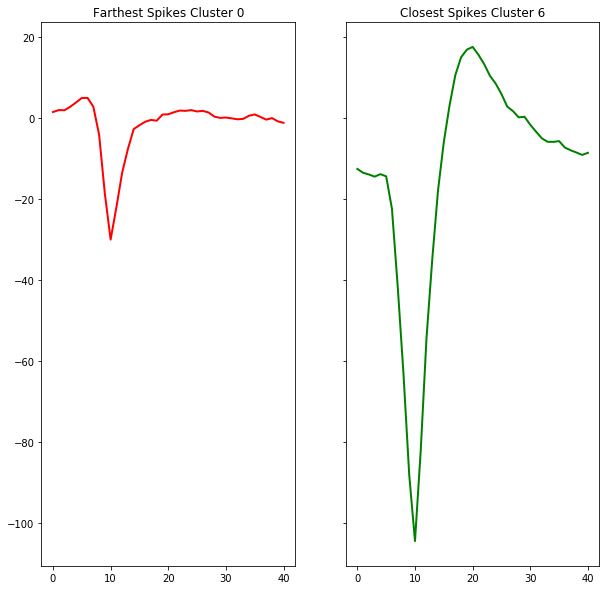

In [17]:
cutouts = np.array(list(H.spikes.Shape[[spike[0] for spike in farthest_spikes]])) 
cutouts2 = np.array(list(H.spikes.Shape[[spike[0] for spike in closest_spikes]]))
cutouts3 = np.array(list(H.spikes.Shape[[spike[0] for spike in closest_spikes165]]))
cutouts4 = np.array(list(H.spikes.Shape[[spike[0] for spike in closest_spikes167]]))
cutouts5 = np.array(list(H.spikes.Shape[[spike[0] for spike in closest_spikes6]]))
cutouts6 = np.array(list(H.spikes.Shape[[spike[0] for spike in closest_spikes134]]))

cutouts_whole_0 = np.array(list(H.spikes.Shape[[spike for spike in cluster_0]])) 
cutouts_whole_170 = np.array(list(H.spikes.Shape[[spike for spike in cluster_134]])) 

#f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True, sharey=True)
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
f.set_figheight(10)
f.set_figwidth(10)

#ax1.plot(cutouts[0] - np.median(cutouts[0], axis=0), 'red', lw=2)
ax1.plot(np.mean(cutouts2, axis=0), 'red', lw=2)

ax1.set_title("Farthest Spikes Cluster 0")

cluster = 6

if cluster == 0:
    #ax2.plot(np.mean(cutouts2[:100], axis=0), 'green', lw=2)
    ax2.plot(cutouts2[20], 'green', lw=2)
    ax2.set_title("Closest Spikes Cluster 0")
if cluster == 16:
    ax2.plot(np.mean(cutouts3[:100], axis=0), 'green', lw=2)
    ax2.set_title("Closest Spikes Cluster 165")
    
if cluster == 167:
    ax2.plot(np.mean(cutouts4[:100], axis=0))
    #ax2.plot(cutouts4[0], 'green', lw=2)
    ax2.set_title("Closest Spikes Cluster 167")
    
if cluster == 6:
    ax2.plot(np.mean(cutouts5[:50], axis=0) - np.median(np.mean(cutouts5[:1], axis=0), axis=0), 'green', lw=2)
    #ax2.plot(np.mean(cutouts5[:10], axis=0), 'green', lw=2)
    #ax2.plot(cutouts5[0], 'green', lw=2)
    ax2.set_title("Closest Spikes Cluster 6")
    
if cluster == 134:
    ax2.plot(np.mean(cutouts6, axis=0), 'green', lw=2)
    #ax2.plot(cutouts6[0], 'green', lw=2)
    ax2.set_title("Closest Spikes Cluster 134")

spike = farthest_spikes[0][0]
spike_dist_from_cluster = [(cl_id, np.sqrt(((H.fourvec[spike] - center)**2).sum())) for cl_id, center in enumerate(H.centerz)]
closest_clusters = heapq.nsmallest(50,spike_dist_from_cluster, key=lambda X: X[1])
print(closest_clusters)
#tuples0 = [(spike, np.sqrt(((H.fourvec[spike] - H.centerz[0])**2).sum())) for cl_id, center in enumerate(H.centerz)]
    
#ax3.plot(cutouts3[0], 'blue', lw=2)
#ax3.set_title("Closest Spikes Cluster 165")
#ax4.plot(cutouts4[0], 'blue', lw=2)
#ax4.set_title("Closest Spikes Cluster 167")
#ax5.plot(cutouts5[0], 'blue', lw=2)
#ax5.set_title("Closest Spikes Cluster 6")
#ax6.plot(cutouts6[0], 'blue', lw=2)
#ax6.set_title("Closest Spikes Cluster 170")                   
#ax1.plot(np.mean(cutouts, axis=0), 'red', lw=4)
#ax2.plot(np.mean(cutouts2, axis=0), 'green', lw=4)

In [ ]:
import pywt
from statsmodels.robust import mad

sym4= pywt.Wavelet('sym4')
cutout_far0 = cutouts[0][1:] - np.mean(cutouts[0])
cutout_close0 = cutouts2[0][1:] - np.mean(cutouts2[0])

#cutout_center0 = cutout_center0 - np.mean(cutout_center0)

#for element in cutout_center0:
 #   if(element < 0):
 #       if (element > -10):
  #          element = 0
 #   else:
 #       if(element > 5):
  #          element = 0

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
f.set_figheight(10)
f.set_figwidth(5)

#ax1.plot(cutouts[0] - np.median(cutouts[0], axis=0), 'red', lw=2)
ax1.plot(cutout_far0, 'red', lw=2)
ax1.set_title("Farthest Spike Cluster 0")
ax3.plot(cutout_close0, 'red', lw=2)
ax3.set_title("Closest Spike Cluster 0")


#SWT transform of cutout and thresholding
coefficients = pywt.swt(cutout_far0, sym4, level=2)
coefficients2 = pywt.swt(cutout_close0, sym4, level=2)

universal = False
if(universal):
    sigma = np.median(coefficients[-1][1])/0.6745
    #sigma = mad(coefficients[-1]) #omit smoothing coefficients
    uthresh = sigma*np.sqrt(2*np.log(len(coefficients[0])))
    new_coefficients = coefficients[:]
    new_coefficients = pywt.threshold(new_coefficients, uthresh, 'hard')
    ax2.plot(pywt.iswt(new_coefficients,'sym4') , 'blue', lw=2)
    
    sigma = np.median(coefficients[-1][1])/0.6745
    #sigma = mad(coefficients2[-1]) #omit smoothing coefficients
    uthresh = sigma*np.sqrt(2*np.log(len(coefficients2[0])))
    new_coefficients = coefficients2[:]
    new_coefficients = pywt.threshold(new_coefficients, uthresh, 'hard')
    ax4.plot(pywt.iswt(new_coefficients,'sym4') , 'blue', lw=2)
else:
    new_coefficients = coefficients[:]
    new_coefficients = pywt.threshold(new_coefficients, 10, 'soft')
    ax2.plot(pywt.iswt(new_coefficients,'sym4') , 'green', lw=2)
    
    new_coefficients = coefficients2[:]
    new_coefficients = pywt.threshold(new_coefficients, 10, 'soft')
    ax4.plot(pywt.iswt(new_coefficients,'sym4') , 'blue', lw=2)
    
#print(cutouts_mean)
#ax2.plot(cA1, 'blue', lw=2)
#ax2.plot(cD1, 'green', lw=2)
#ax2.plot(cA2, 'red', lw=2)
##ax2.plot(cD2, 'purple', lw=2)

#ax1.plot(pywt.iswt([(cA1, cD1)],'sym4') , 'blue', lw=2)

ax2.set_title("SWT Reconstruction Farthest Cluster 0")
ax4.set_title("SWT Reconstruction Closest Cluster 0")

#if cluster == 0:
 #   ax2.plot(np.mean(cutouts2[:100], axis=0), 'green', lw=2)
    #ax2.plot(cutouts2[0], 'green', lw=2)
 #  ax2.set_title("Closest Spikes Cluster 0")

In [ ]:
sym4= pywt.Wavelet('sym4')
cutout_far0 = cutouts[0][:40] - np.mean(cutouts[0])

#cutout_center0 = cutout_center0 - np.mean(cutout_center0)

#for element in cutout_center0:
 #   if(element < 0):
 #       if (element > -10):
  #          element = 0
 #   else:
 #       if(element > 5):
  #          element = 0

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
f.set_figheight(10)
f.set_figwidth(10)

#ax1.plot(cutouts[0] - np.median(cutouts[0], axis=0), 'red', lw=2)
ax1.plot(cutout_far0, 'red', lw=2)
ax1.set_title("Farthest Spike Cluster 0")


#SWT transform of cutout and thresholding
coefficients = pywt.swt(cutout_far0, sym4, level=2)

universal = False
if(universal):
    sigma = mad(coefficients[-1]) #omit smoothing coefficients
    uthresh = sigma*np.sqrt(2*np.log(len(coefficients[0])))
    new_coefficients = coefficients[:]
    new_coefficients = pywt.threshold(new_coefficients, uthresh, 'hard')
    ax2.plot(pywt.iswt(new_coefficients,'sym4') , 'blue', lw=2)
    
else:
    new_coefficients = coefficients[:]
    new_coefficients = pywt.threshold(new_coefficients, 15, 'hard')
    ax2.plot(pywt.iswt(new_coefficients,'sym4') , 'green', lw=2)
#print(cutouts_mean)
#ax2.plot(cA1, 'blue', lw=2)
#ax2.plot(cD1, 'green', lw=2)
#ax2.plot(cA2, 'red', lw=2)
##ax2.plot(cD2, 'purple', lw=2)

#ax1.plot(pywt.iswt([(cA1, cD1)],'sym4') , 'blue', lw=2)

ax2.set_title("SWT Reconstruction Farthest Cluster 0")
print(new_coefficients)
#if cluster == 0:
 #   ax2.plot(np.mean(cutouts2[:100], axis=0), 'green', lw=2)
    #ax2.plot(cutouts2[0], 'green', lw=2)
 #  ax2.set_title("Closest Spikes Cluster 0")

In [ ]:
X = []
from random import shuffle
import random
clusters = [cutouts2[:80], cutouts3[:80], cutouts4[:80], cutouts5[:80], cutouts6[:80]]
for cutouts_clusters in clusters:
    for cutout in cutouts_clusters:
        coefficients = pywt.swt(cutout[1:], sym4, level=2)
        new_coefficients = coefficients[:]
        new_coefficients = pywt.threshold(new_coefficients, 10, 'soft')
        data_point = []
        for level in new_coefficients:
            for coefficient_list in level:
                for element in coefficient_list:
                    data_point = [element] + data_point
        X.append(data_point)
Y = []        
for i in range(len(X)):
    if i < 50:
        Y.append(0)
    elif i < 100:
        Y.append(165)
    elif i < 150:
        Y.append(167)
    elif i < 200:
        Y.append(6)
    elif i < 250:
        Y.append(170)

c = list(zip(X, Y))
random.shuffle(c)
X, Y = zip(*c)


In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X, Y)

#cutouts2 = cluster 0
#cutouts3 = cluster 165
#cutouts4 = 167
#cutouts5 = 6
#cutouts6 = 170

cutout_full0 = np.array(list([H.spikes.Shape[spike] for spike in cluster_0])) 

to_predict = []
for cutout in cutout_full0:
    coefficients = pywt.swt(cutout[1:], sym4, level=2)
    new_coefficients = coefficients[:]
    new_coefficients = pywt.threshold(new_coefficients, 10, 'soft')
    data_point = []
    for level in new_coefficients:
            for coefficient_list in level:
                for element in coefficient_list:
                    data_point = [element] + data_point
    to_predict.append(data_point)
correct = 0
wrong = 0
for elem in clf.predict(to_predict):
    if(elem == 170):
        correct += 1
    if(elem !=170):
        wrong += 1
print(correct/(correct + wrong))